In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d gpiosenka/cats-in-the-wild-image-classification
from zipfile import ZipFile
file_name = "/content/cats-in-the-wild-image-classification.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

 99% 122M/123M [00:06<00:00, 26.9MB/s]
100% 123M/123M [00:06<00:00, 19.4MB/s]
Done


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL

import os
import cv2


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
img_gen = ImageDataGenerator(rescale=1/255)

In [43]:
train = img_gen.flow_from_directory(directory='/content/train', target_size=(224,224), seed=42)
test = img_gen.flow_from_directory(directory='/content/test', target_size=(224,224), seed=42)
val = img_gen.flow_from_directory(directory='/content/valid', target_size=(224,224), seed=42)


Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [44]:
train_dataset = keras.utils.image_dataset_from_directory('/content/train',
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(224, 224))

Found 2339 files belonging to 10 classes.


In [45]:
val_dataset = keras.utils.image_dataset_from_directory('/content/valid',
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(224, 224))

Found 50 files belonging to 10 classes.


In [46]:
test_dataset = keras.utils.image_dataset_from_directory('/content/test',
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(224, 224))

Found 50 files belonging to 10 classes.


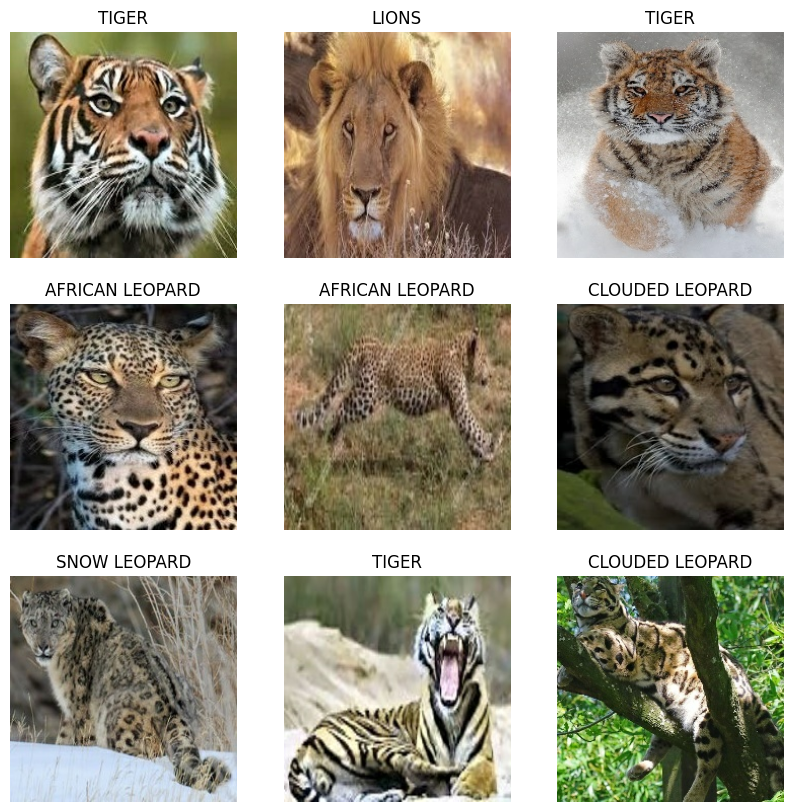

In [47]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [49]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

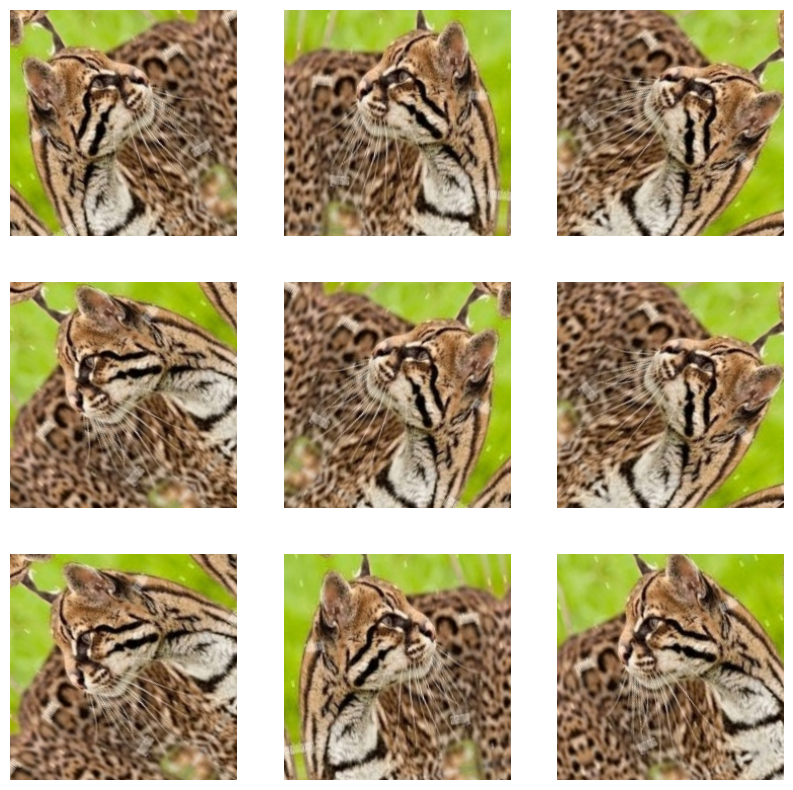

In [50]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [51]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [52]:

base_model = tf.keras.applications.EfficientNetB1(input_shape=(224,224,3),
                                                 include_top=False,
                                                 weights='imagenet')

In [53]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                     

In [54]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape, label_batch.shape)

(32, 7, 7, 1280) (32,)


In [55]:
base_model.trainable = False

In [56]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                     

In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [58]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [60]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [61]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
print("Shape of label_batch:", label_batch.shape)
print("Shape of prediction_batch:", prediction_batch.shape)


Shape of label_batch: (32, 10)
Shape of prediction_batch: (32, 10)


In [62]:
# Efficentnetb1
train_metrics = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=6
)

Epoch 1/6
74/74 [==============================] - 236s 3s/step - loss: 2.0746 - accuracy: 0.2984 - val_loss: 1.8339 - val_accuracy: 0.5400
Epoch 2/6
74/74 [==============================] - 217s 3s/step - loss: 1.6590 - accuracy: 0.5926 - val_loss: 1.4770 - val_accuracy: 0.7800
Epoch 3/6
74/74 [==============================] - 217s 3s/step - loss: 1.3647 - accuracy: 0.7460 - val_loss: 1.2019 - val_accuracy: 0.8400
Epoch 4/6
74/74 [==============================] - 221s 3s/step - loss: 1.1305 - accuracy: 0.8333 - val_loss: 0.9924 - val_accuracy: 0.9000
Epoch 5/6
74/74 [==============================] - 214s 3s/step - loss: 0.9603 - accuracy: 0.8508 - val_loss: 0.8342 - val_accuracy: 0.9200
Epoch 6/6
74/74 [==============================] - 221s 3s/step - loss: 0.8235 - accuracy: 0.8760 - val_loss: 0.7132 - val_accuracy: 0.9400


In [63]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                           

In [66]:
model.evaluate(test_dataset)

2/2 [==============================] - 10s 3s/step - loss: 0.7222 - accuracy: 0.9400


[0.7221548557281494, 0.9399999976158142]

In [ ]:
len(model.trainable_variables)

In [75]:
# Efficentnetb1
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_dataset)

2/2 [==============================] - 7s 2s/step - loss: 0.7112 - accuracy: 0.9400


In [76]:
base_model.trainable = True

In [77]:
len(base_model.layers)

340

In [78]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:338]:
  layer.trainable = False


Number of layers in the base model:  340


In [79]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [80]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                     

In [81]:
initial_epochs = 6

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=train_metrics.epoch[-1],
                         validation_data=val_dataset)

Epoch 6/11
74/74 [==============================] - 243s 3s/step - loss: 0.7039 - accuracy: 0.8970 - val_loss: 0.5751 - val_accuracy: 0.9800
Epoch 7/11
74/74 [==============================] - 215s 3s/step - loss: 0.6054 - accuracy: 0.9021 - val_loss: 0.4813 - val_accuracy: 0.9800
Epoch 8/11
74/74 [==============================] - 216s 3s/step - loss: 0.5318 - accuracy: 0.9077 - val_loss: 0.4151 - val_accuracy: 0.9800
Epoch 9/11
74/74 [==============================] - 217s 3s/step - loss: 0.4844 - accuracy: 0.9132 - val_loss: 0.3635 - val_accuracy: 0.9800
Epoch 10/11
74/74 [==============================] - 218s 3s/step - loss: 0.4401 - accuracy: 0.9218 - val_loss: 0.3238 - val_accuracy: 0.9800
Epoch 11/11
74/74 [==============================] - 215s 3s/step - loss: 0.3951 - accuracy: 0.9290 - val_loss: 0.2905 - val_accuracy: 0.9800


In [84]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
model.evaluate(test_dataset, batch_size=32)

2/2 [==============================] - 7s 1s/step - loss: 0.2919 - accuracy: 0.9600


[0.29190272092819214, 0.9599999785423279]

In [94]:
import tensorflow as tf

tf.saved_model.save(model, '/content/drive/MyDrive/Colab Notebooks/CNN_Model/animals_model')


In [96]:
loaded_model = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/CNN_Model/animals_model')
